In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:


file_path = 'dateKNN.csv'
data = pd.read_csv(file_path)


data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)


data['target'] = np.where(data['return_1m'] > 0, 1, 0)


X = data.drop(columns=['ticker', 'target'])
y = data['target'].values


imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


preprocessed_data = pd.DataFrame(X_scaled, index=data.index, columns=X.columns)
preprocessed_data.to_csv('preprocessed_data.csv', index=True)

In [10]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


knn = KNeighborsClassifier()
cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {cv_scores.mean()}')


param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_}')


best_knn = grid_search.best_estimator_
best_knn.fit(X_train, y_train)

Cross-validation scores: [0.89058524 0.88464801 0.88210348 0.885181   0.89423077]
Mean cross-validation score: 0.8873496981489797
Best parameters found: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Best cross-validation score: 0.9041453822998502


KNeighborsClassifier(metric='manhattan', n_neighbors=11)

Accuracy: 0.9049988690341552
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1918
           1       0.90      0.93      0.92      2503

    accuracy                           0.90      4421
   macro avg       0.91      0.90      0.90      4421
weighted avg       0.91      0.90      0.90      4421



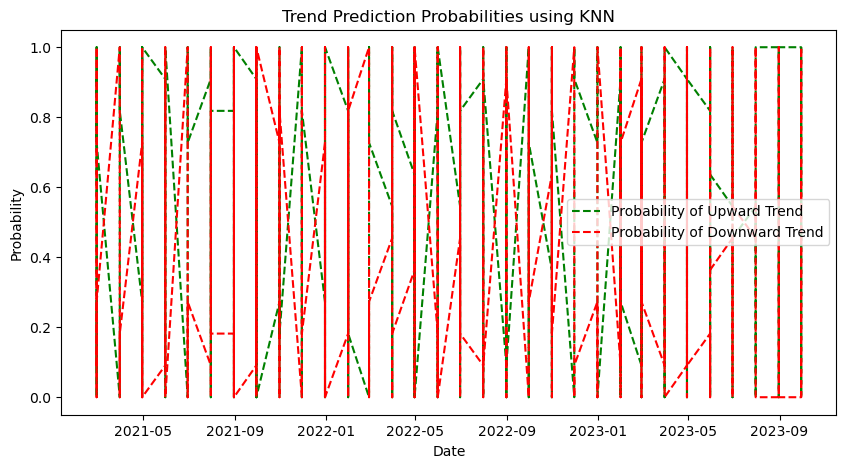

In [11]:


y_pred = best_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))


y_prob = best_knn.predict_proba(X_test)


plt.figure(figsize=(10, 5))
plt.plot(data.index[-len(y_test):], y_prob[:, 1], label='Probability of Upward Trend', linestyle='--', color='green')
plt.plot(data.index[-len(y_test):], y_prob[:, 0], label='Probability of Downward Trend', linestyle='--', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Probability')
plt.title('Trend Prediction Probabilities using KNN')
plt.show()


In [12]:


last_row = X.iloc[-1].values.reshape(1, -1)
future_data = np.tile(last_row, (30, 1))


future_data_imputed = imputer.transform(future_data)


future_data_scaled = scaler.transform(future_data_imputed)


future_prob = best_knn.predict_proba(future_data_scaled)


future_predictions = pd.DataFrame({
    'date': pd.date_range(start=data.index[-1], periods=30, freq='D'),
    'probability_upward': future_prob[:, 1],
    'probability_downward': future_prob[:, 0]
})


/home/vlad/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


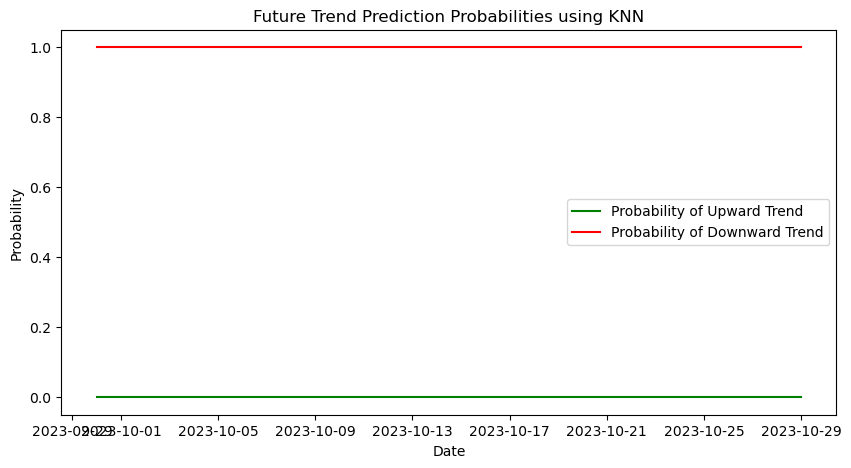

In [13]:
# Salvăm rezultatele prognozei într-un fișier CSV
future_predictions.to_csv('future_predictions.csv', index=False)

# Vizualizăm probabilitățile prognozate pentru datele viitoare
plt.figure(figsize=(10, 5))
plt.plot(future_predictions['date'], future_predictions['probability_upward'], label='Probability of Upward Trend', color='green')
plt.plot(future_predictions['date'], future_predictions['probability_downward'], label='Probability of Downward Trend', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Probability')
plt.title('Future Trend Prediction Probabilities using KNN')
plt.show()


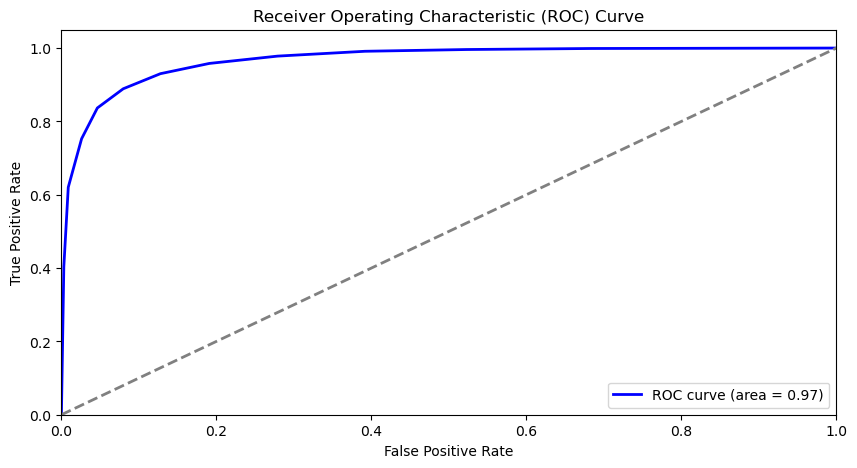

In [14]:

fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


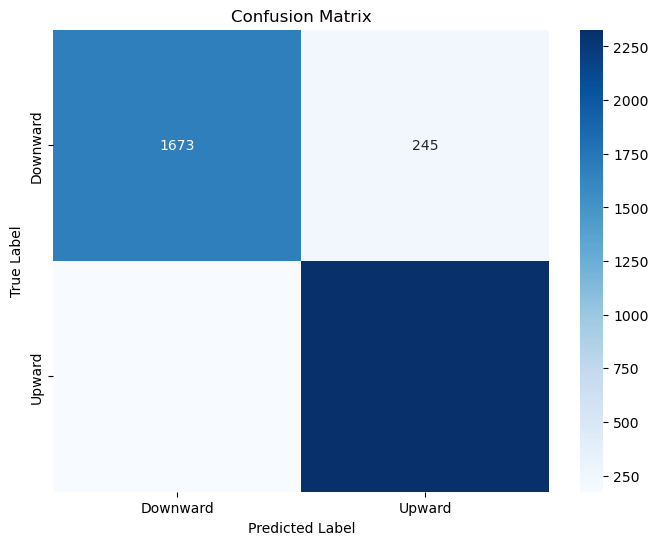

In [15]:
# Matricea de Confuzie
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Downward', 'Upward'], yticklabels=['Downward', 'Upward'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



/home/vlad/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/vlad/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


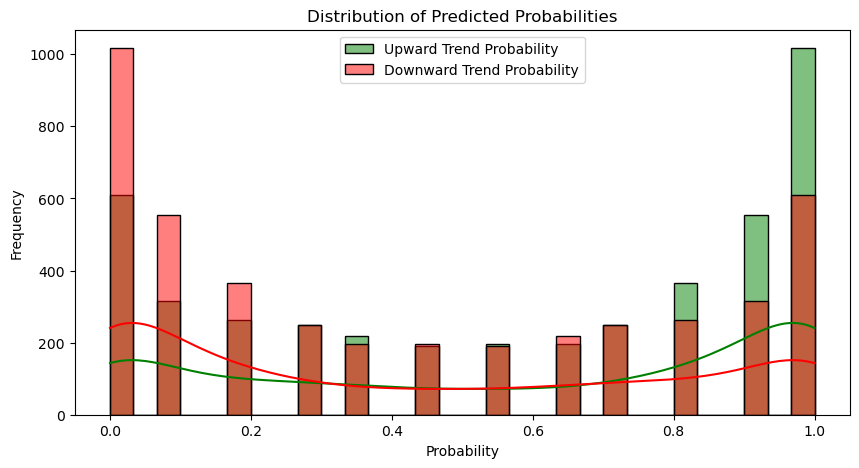

In [16]:

plt.figure(figsize=(10, 5))
sns.histplot(y_prob[:, 1], kde=True, bins=30, color='green', label='Upward Trend Probability')
sns.histplot(y_prob[:, 0], kde=True, bins=30, color='red', label='Downward Trend Probability')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()

target
1    12566
0     9538
Name: count, dtype: int64


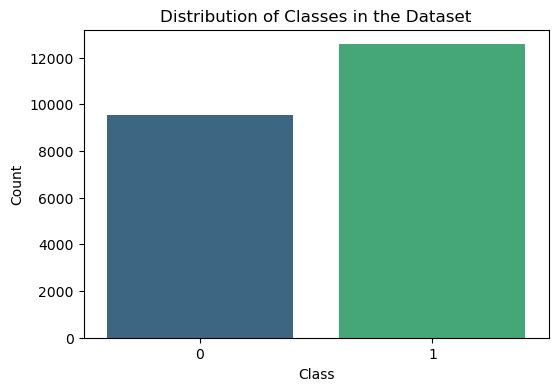

In [19]:

class_counts = data['target'].value_counts()
print(class_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes in the Dataset')
plt.show()


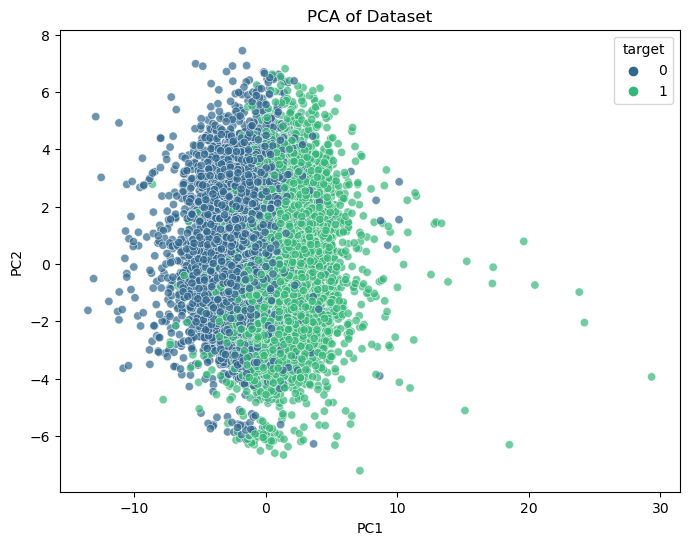

In [20]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['target'] = y


plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='target', data=pca_df, palette='viridis', alpha=0.7)
plt.title('PCA of Dataset')
plt.show()


Cross-validation scores: [0.89058524 0.88464801 0.88210348 0.885181   0.89423077]
Mean cross-validation score: 0.8873496981489797
Best parameters found: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Best cross-validation score: 0.9041453822998502
Accuracy: 0.9049988690341552
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1918
           1       0.90      0.93      0.92      2503

    accuracy                           0.90      4421
   macro avg       0.91      0.90      0.90      4421
weighted avg       0.91      0.90      0.90      4421



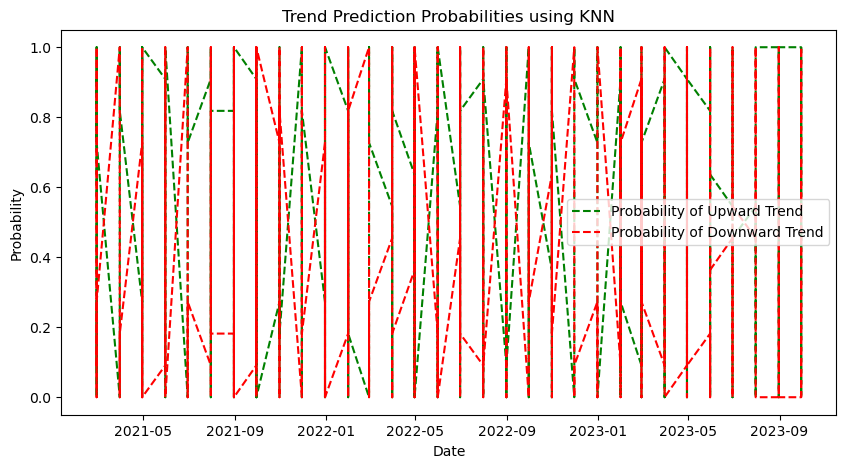

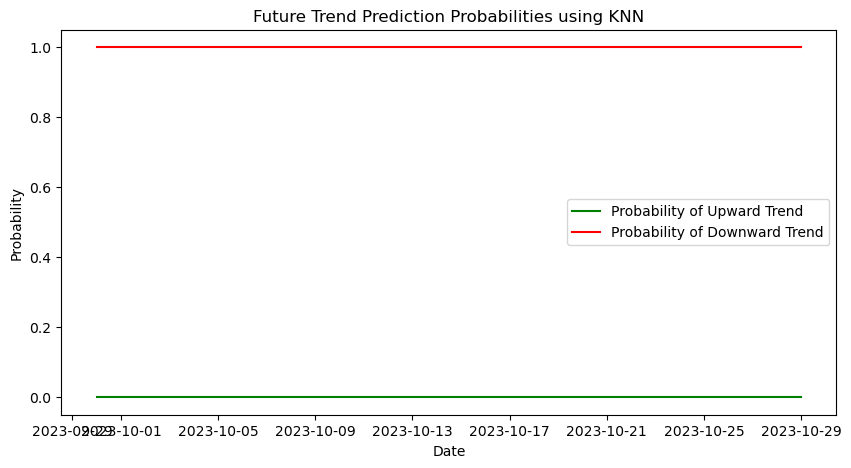

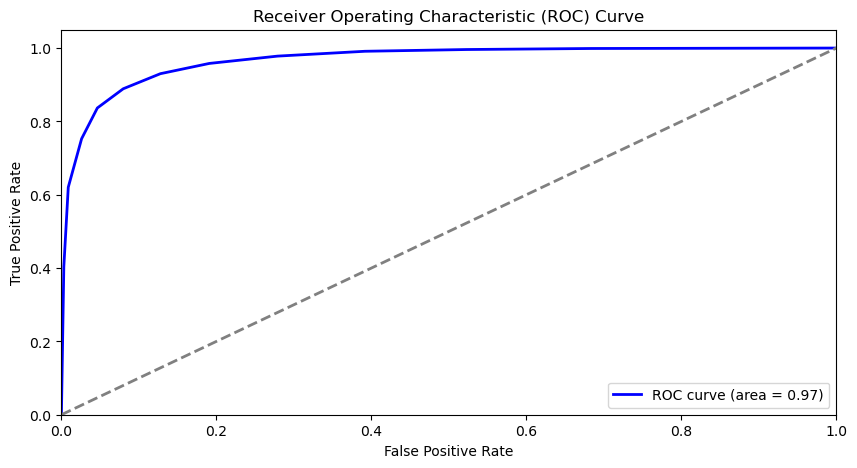

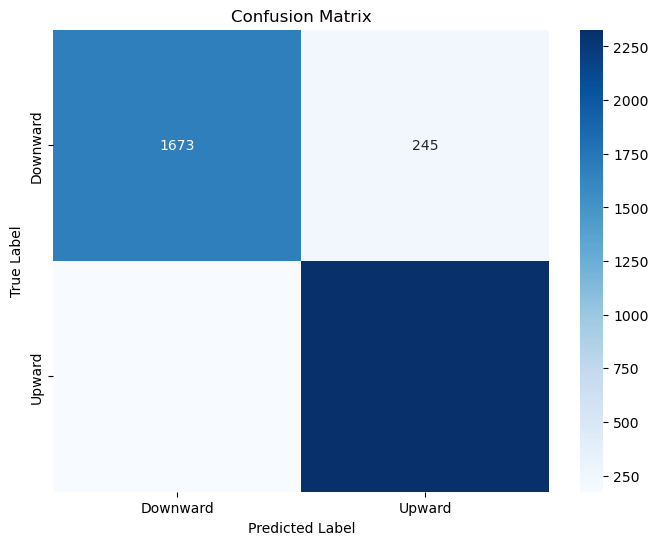

/home/vlad/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/vlad/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


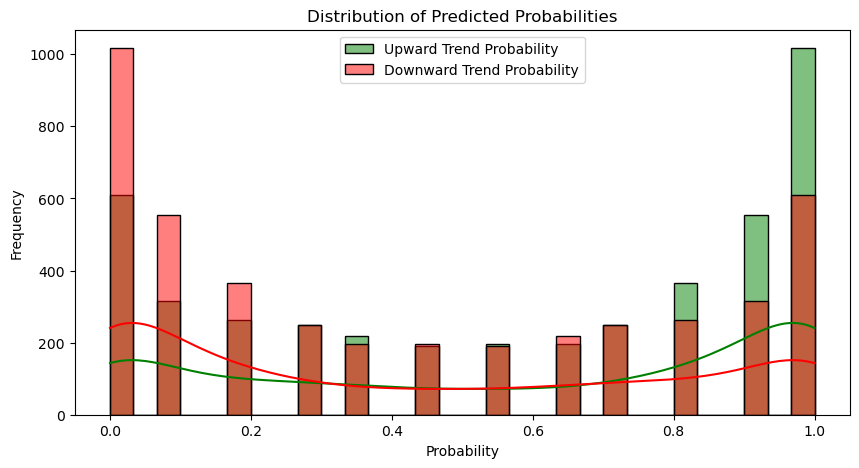

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'dateKNN.csv'
data = pd.read_csv(file_path)


data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)


data['target'] = np.where(data['return_1m'] > 0, 1, 0)


X = data.drop(columns=['ticker', 'target'])
y = data['target'].values


imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

preprocessed_data = pd.DataFrame(X_scaled, index=data.index, columns=X.columns)
preprocessed_data.to_csv('preprocessed_data.csv', index=True)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


knn = KNeighborsClassifier()
cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {cv_scores.mean()}')


param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_}')


best_knn = grid_search.best_estimator_
best_knn.fit(X_train, y_train)


y_pred = best_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

y_prob = best_knn.predict_proba(X_test)


plt.figure(figsize=(10, 5))
plt.plot(data.index[-len(y_test):], y_prob[:, 1], label='Probability of Upward Trend', linestyle='--', color='green')
plt.plot(data.index[-len(y_test):], y_prob[:, 0], label='Probability of Downward Trend', linestyle='--', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Probability')
plt.title('Trend Prediction Probabilities using KNN')
plt.show()


last_row = pd.DataFrame(X.iloc[-1].values.reshape(1, -1), columns=X.columns)
future_data = pd.concat([last_row] * 30, ignore_index=True)


future_data_imputed = imputer.transform(future_data)


future_data_scaled = scaler.transform(future_data_imputed)

future_prob = best_knn.predict_proba(future_data_scaled)


future_predictions = pd.DataFrame({
    'date': pd.date_range(start=data.index[-1], periods=30, freq='D'),
    'probability_upward': future_prob[:, 1],
    'probability_downward': future_prob[:, 0]
})


future_predictions.to_csv('future_predictions.csv', index=False)


plt.figure(figsize=(10, 5))
plt.plot(future_predictions['date'], future_predictions['probability_upward'], label='Probability of Upward Trend', color='green')
plt.plot(future_predictions['date'], future_predictions['probability_downward'], label='Probability of Downward Trend', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Probability')
plt.title('Future Trend Prediction Probabilities using KNN')
plt.show()


fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Downward', 'Upward'], yticklabels=['Downward', 'Upward'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


plt.figure(figsize=(10, 5))
sns.histplot(y_prob[:, 1], kde=True, bins=30, color='green', label='Upward Trend Probability')
sns.histplot(y_prob[:, 0], kde=True, bins=30, color='red', label='Downward Trend Probability')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()
